In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [27]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [29]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [30]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [31]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [32]:
# Use `engine.execute` to select and display the first 10 rows from the measurement table
result = engine.execute("select *  from station").fetchall()
#engine.execute('select * from measurement').fetchall()
print(result[:10])

[(0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.914), (1, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45), (2, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 2.133), (3, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 3.627), (4, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 93.447), (5, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 5.943), (6, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84889, 10.027), (7, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.274), (8, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 46.449)]


In [33]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [34]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date

'2017-08-23'

<function matplotlib.pyplot.show(close=None, block=None)>

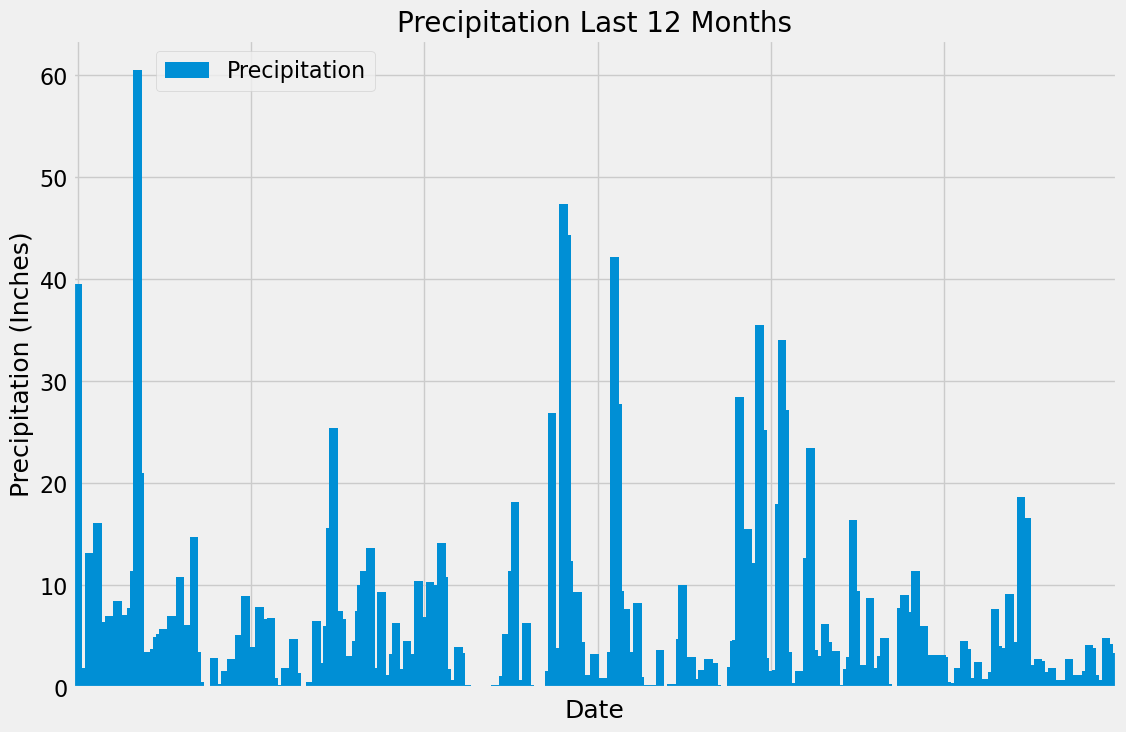

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
date_end = latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date
# Calculate the date one year from the last date in data set.
last_twelve_months = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_twelve_months

# Perform a query to retrieve the data and precipitation scores
p_results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_twelve_months).\
                    group_by(Measurement.date).all()
p_results

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(p_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.head()
# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
# Plot the precipitation for the past 12 months
ax = precipitation_df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.savefig("../Precipitation.png")
plt.show

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,365.000000
mean,4.320637
std,7.509807
min,0.000000
25%,0.233333
50%,1.800000
75%,4.866667
max,60.450000


# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [40]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
s_results = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
s_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
best_station = s_results[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(12.2, 22.03582251082252, 29.4)]

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best_station).\
                filter(Measurement.date >= last_twelve_months).all()
tobs_df = pd.DataFrame(t_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,25.0
USC00519281,26.7
USC00519281,26.7
USC00519281,23.9
USC00519281,22.8


In [53]:
#Plot results
high_station_temp=pd.DataFrame(t_results,columns=['tobs'])
high_station_temp.plot.hist(bins=12)
plt.tight_layout()
plt.title("12 month Temperature Histogram", size=13)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


ValueError: 1 columns passed, passed data had 2 columns

In [50]:
# Plot the results as a histogram with bins=12.
tobs_df.plot.hist(by=['station'], bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + best_station, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("../StationTemps.png")
plt.show

KeyError: "['station'] not in index"

# Close Session

In [16]:
# Close Session
session.close()
